# Setting up the YT API

In [1]:
import json
import requests
from tqdm import tqdm


class YTstats:

    def __init__(self, api_key, channel_id):
        self.api_key = api_key
        self.channel_id = channel_id
        self.channel_statistics = None
        self.video_data = None

    def extract_all(self):
        self.get_channel_statistics()
        self.get_channel_video_data()

    def get_channel_statistics(self):
        """Extract the channel statistics"""
        print('get channel statistics...')
        url = f'https://www.googleapis.com/youtube/v3/channels?part=statistics&id={self.channel_id}&key={self.api_key}'
        pbar = tqdm(total=1)
        
        json_url = requests.get(url)
        data = json.loads(json_url.text)
        try:
            data = data['items'][0]['statistics']
        except KeyError:
            print('Could not get channel statistics')
            data = {}

        self.channel_statistics = data
        pbar.update()
        pbar.close()
        return data

    def get_channel_video_data(self):
        "Extract all video information of the channel"
        print('get video data...')
        channel_videos, channel_playlists = self._get_channel_content(limit=50)

        parts=["snippet", "statistics","contentDetails", "topicDetails"]
        for video_id in tqdm(channel_videos):
            for part in parts:
                data = self._get_single_video_data(video_id, part)
                channel_videos[video_id].update(data)

        self.video_data = channel_videos
        return channel_videos

    def _get_single_video_data(self, video_id, part):
        """
        Extract further information for a single video
        parts can be: 'snippet', 'statistics', 'contentDetails', 'topicDetails'
        """

        url = f"https://www.googleapis.com/youtube/v3/videos?part={part}&id={video_id}&key={self.api_key}"
        json_url = requests.get(url)
        data = json.loads(json_url.text)
        try:
            data = data['items'][0][part]
        except KeyError as e:
            print(f'Error! Could not get {part} part of data: \n{data}')
            data = dict()
        return data

    def _get_channel_content(self, limit=None, check_all_pages=True):
        """
        Extract all videos and playlists, can check all available search pages
        channel_videos = videoId: title, publishedAt
        channel_playlists = playlistId: title, publishedAt
        return channel_videos, channel_playlists
        """
        url = f"https://www.googleapis.com/youtube/v3/search?key={self.api_key}&channelId={self.channel_id}&part=snippet,id&order=date"
        if limit is not None and isinstance(limit, int):
            url += "&maxResults=" + str(limit)

        vid, pl, npt = self._get_channel_content_per_page(url)
        idx = 0
        while(check_all_pages and npt is not None and idx < 10):
            nexturl = url + "&pageToken=" + npt
            next_vid, next_pl, npt = self._get_channel_content_per_page(nexturl)
            vid.update(next_vid)
            pl.update(next_pl)
            idx += 1

        return vid, pl

    def _get_channel_content_per_page(self, url):
        """
        Extract all videos and playlists per page
        return channel_videos, channel_playlists, nextPageToken
        """
        json_url = requests.get(url)
        data = json.loads(json_url.text)
        channel_videos = dict()
        channel_playlists = dict()
        if 'items' not in data:
            print('Error! Could not get correct channel data!\n', data)
            return channel_videos, channel_videos, None

        nextPageToken = data.get("nextPageToken", None)

        item_data = data['items']
        for item in item_data:
            try:
                kind = item['id']['kind']
                published_at = item['snippet']['publishedAt']
                title = item['snippet']['title']
                if kind == 'youtube#video':
                    video_id = item['id']['videoId']
                    channel_videos[video_id] = {'publishedAt': published_at, 'title': title}
                elif kind == 'youtube#playlist':
                    playlist_id = item['id']['playlistId']
                    channel_playlists[playlist_id] = {'publishedAt': published_at, 'title': title}
            except KeyError as e:
                print('Error! Could not extract data from item:\n', item)

        return channel_videos, channel_playlists, nextPageToken

    def dump(self):
        """Dumps channel statistics and video data in a single json file"""
        if self.channel_statistics is None or self.video_data is None:
            print('data is missing!\nCall get_channel_statistics() and get_channel_video_data() first!')
            return

        fused_data = {self.channel_id: {"channel_statistics": self.channel_statistics,
                              "video_data": self.video_data}}

        channel_title = self.video_data.popitem()[1].get('channelTitle', self.channel_id)
        channel_title = channel_title.replace(" ", "_").lower()
        filename = channel_title + '.json'
        with open(filename, 'w') as f:
            json.dump(fused_data, f, indent=4)
        
        print('file dumped to', filename)

In [3]:
API_KEY = ''
channel_id = 'UCKbbjKo0BSaNB99FcY9bSPQ'


In [126]:
!pip install python-youtube

     |████████████████████████████████| 41 kB 244 kB/s eta 0:00:011
     |████████████████████████████████| 47 kB 6.3 MB/s eta 0:00:011
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3576 sha256=8494f35e31bdd0595e93744789af7295884ab1308b8cce50b0ab51e9d7fd0535
  Stored in directory: /Users/home/Library/Caches/pip/wheels/04/0e/31/bf265c64f2a4d24516e9923f1f6293c3bcbcde75e0d80ab47a
Successfully built stringcase


In [196]:
# extract channel info and all videos with detailed info
def create_json_yt(channel_ids, API_KEY):
    for channel_id in channel_ids:
        if channel_id:
            yt = YTstats(API_KEY, channel_id)
            yt.extract_all()
            yt.dump()  # dumps to .json

In [8]:
#only channel info
yt.get_channel_statistics()

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

get channel statistics...


{'viewCount': '108657354',
 'subscriberCount': '196000',
 'hiddenSubscriberCount': False,
 'videoCount': '1020'}

# Get YT Channel info

In [195]:
def get_channel_stats(API_KEY, channel_id):
    from filename import YTstats # import Class from above
    yt = YTstats(API_KEY, channel_id)
    yt.get_channel_statistics()
    yt.dump()  # dumps to .json

# Get comments from YT

In [125]:
## this needs to be run and stored cold!

In [124]:
from googleapiclient.discovery import build
  
def video_comments(video_id):
    '''Takes a youtube video id and retrieves comments for that video'''
    timeout = 10   # [seconds]

    timeout_start = time.time()

    # empty list for storing reply
    replies = []
    comment = ''
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
  
    # retrieve youtube video results
    video_response=youtube.commentThreads().list(
    part='snippet,replies',
    videoId=video_id
    ).execute()
    df = pd.DataFrame(data=[[comment, replies]], columns=['comments', 'replies'])
    # iterate video response
    while video_response and time.time() < timeout_start + timeout:
        
        # extracting required info
        # from each result object 
        for item in video_response['items']:
            
            # Extracting comments
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            df = df.append({'comments': pd.Series(data=comment)}, ignore_index=True)
            # counting number of reply of comment
            replycount = item['snippet']['totalReplyCount']
  
            # if reply is there
            if replycount>0:
                
                # iterate through all reply
                for reply in item['replies']['comments']:
                    
                    # Extract reply
                    reply = reply['snippet']['textDisplay']
                    
                    # Store reply is list
                    replies.append(reply)
                    df = df.append({'replies': pd.Series(data=replies)}, ignore_index=True)
                    
            # print comment with list of reply
            print(comment, replies, end = '\n\n')
            # empty reply list
            replies = []
        
        # Again repeat
        if 'nextPageToken' in video_response:
            video_response = youtube.commentThreads().list(
                    part = 'snippet,replies',
                    videoId = video_id
                ).execute()
        else:
            break
    return df
# Enter video id
video_id = "4oKiOli9kFU"

In [121]:
## trying to automate the uploading of a file stored in json 
## and the extraction of the video_ids, to then run the above function for all videos

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
%matplotlib inline

with open("noway4u.json") as datafile:
    data = json.load(datafile)
    keys_list = list(data)
    key = keys_list[0]
    video_ids = list(data[key]['video_data'])
    for video in video_ids:
        temp = video_comments(video)
        df = pd.concat([df, temp], axis=1)

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

Min <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=08m12s">08:12</a> Tempo 0,5 :D<br>Noway mit 3 Promille []

Agurin auf kha ist einfach crazy []

Wenn man das Game schon im Stream und bei Agurin gesehen hat :C []

zedzedzedzed []

Heute wieder hops genommen werden von agurin. Gar kein Bock []

<a href="http://www.youtube.com/results?search_query=%23algorithmuskommentar">#algorithmuskommentar</a> []

Vielleicht ne blöde Frage...Aber wieso bauen so viele AD Assassins grade Serpent&#39;s Fang auch wenn die Gegner GAR KEINE Schilde haben? Versteh ich das Item falsch? Von den reinen Stats her wäre es ja schlechter als viele der anderen Lethality Items. ['Sehr wahrscheinlich weil das item so günstig ist und der power spike durch die mythic passiv früher da ist um dann noch schneller zu snowballen']

hättest bei <a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=5m52s">5:52</a> einfach E‘n müssen… []

<a href="https://www.youtube.com/watch?v=mFJipOP2aCE&amp;t=1m53s">1:53<

NameError: name 'df' is not defined

# not relevant (trying NLP)

In [133]:
temp3 = video_comments(video_id)

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []hen Rabadons und Void? - wer lesen kann ist klar im Vorteil! <br>Hier kurz der Wikibeitrag für alle die es

Ab wann ist void eig genau worth? nach einem oder 2 mr items? []

<a href="https://www.youtube.com/watch?v=4oKiOli9kFU&amp;t=2m43s">2:43</a> aber wenn die nicht da wäre wär er auch nicht reingegangen []

Wenn ich noch einmal diese swappie werbung sehe ich schwörs euch bei gott ich bring jemanden um []

Ich fand Noway&#39;s Erklärung zu Void/Rhabba durchaus leicht verständlich. Nur vielleicht nicht auf Twitch Chat Niveau. []

Warum machst du die Zeit und die Kills oben rechts weg aber die Zeit im chat nicht ? @ []

Ich hab im replay nachgeschaut, der Auto attack hat ihn in der base getroffen. []

Hat du es schon mal gesehen? []

Da hat wer der Spinne die Beine ausgerissen 😂 []

Wir nehmen einfach Tristana und schieben sie woanders hin.<br>So ein dümmer Champ mit All in Support auf Level 3 bist du tot ['*dummer']

1810 likes zu 0 dislikes &lt;3 []

<br>36% at 200 magic resistance. []

Einfach 1690 likes und 0 dislikes []

like dislike verhältnis mal wieder komplett am übertreiben []

Ich

In [156]:
word_cloud_text = ' '.join(str(v) for v in listen)

In [167]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import string
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = set(stopwords.words('german'))

In [168]:
def clean_text(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    text = "".join(word for word in text if not word.isdigit()).lower()
    word_tokens = word_tokenize(text)
    text = [w for w in word_tokens if not w in stop_words]
    return ' '.join(text)

In [192]:
temp3["clean_comments"] = temp3.comments.apply(lambda x: str(x).strip("dtype objec"))

temp3["clean_comments"] = temp3.clean_comments.apply(lambda x: clean_text(x))

temp3["clean_comments"] = temp3.clean_comments.apply(lambda x: str(x).strip("dtype"))

comment_list = temp3.clean_comments.to_list()
word_cloud_text = ' '.join(str(v) for v in comment_list)

In [190]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Tuned TFidfvectorizer
vec = TfidfVectorizer(ngram_range = (2,2), min_df=0.01, max_df = 0.05).fit(temp3.clean_comments)

vectors = vec.transform(temp3.clean_comments) # Transform text to vectors

sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in     vec.vocabulary_.items()]  # Get the word and associated weight

sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

sorted_tfidf_list

[('dislikes lt', 37.0),
 ('unterschied rabadon', 37.0),
 ('infach likes', 37.0),
 ('wow dislikes', 37.0),
 ('swappie werbung', 26.162950903902246),
 ('werbung seh', 26.162950903902246),
 ('schon mal', 26.162950903902246),
 ('mal gesehen', 26.162950903902246),
 ('hema void', 26.162950903902246),
 ('void rabadons', 26.162950903902246),
 ('unsh gegnerische', 26.162950903902246),
 ('gegnerische elise', 26.162950903902246),
 ('fand noways', 21.361959960016165),
 ('noways erklärung', 21.361959960016165),
 ('erklärung voidrhabba', 21.361959960016165),
 ('replay nachgeschaut', 21.361959960016165),
 ('nachgeschaut auto', 21.361959960016165),
 ('auto attac', 21.361959960016165),
 ('wer spinne', 21.361959960016165),
 ('spinne beine', 21.361959960016165),
 ('beine ausgerissen', 21.361959960016165),
 ('nehmen einfach', 21.361959960016165),
 ('einfach tristana', 21.361959960016165),
 ('tristana schieben', 21.361959960016165),
 ('like dislike', 18.5),
 ('dislike verhältnis', 18.5),
 ('verhältnis mal'

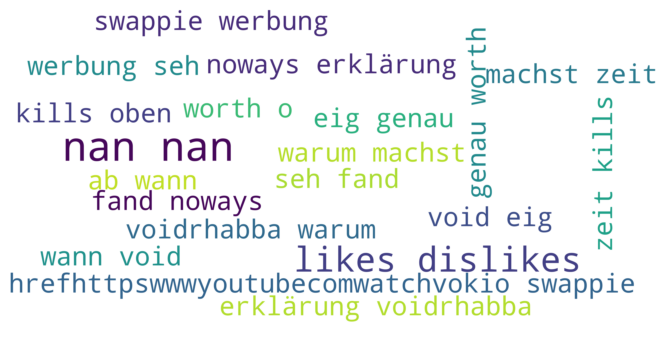

In [193]:

# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

wordcloud = WordCloud(max_font_size=50, # Maximum font size for the largest word
                      max_words=20, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()